# Geokr

## Initialize

In [1]:
import json
from flickr import Flickr

with open('.config') as fp:
    config = json.load(fp)

flickr = Flickr(config['API_KEY'])

# Géolocalization

## Get photos

In [2]:
geoLocalized = [photo for photo in flickr.loadDataFromFile('data15000JustGeo.json') if photo["latitude"] != 0 and photo["longitude"] != 0]

## Get the coordinates from data

In [3]:
import numpy as np

coordinates = [[photo["latitude"], photo["longitude"]] for photo in geoLocalized]

print "%d images localisées" % len(coordinates)

coordinates = np.array(coordinates, dtype=float)

14956 images localisées


## DBSCAN

In [4]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=10,min_samples=40).fit(coordinates)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)

print 'Estimated number of clusters: %d' % n_clusters_
print "Silhouette Coefficient: %0.3f" % metrics.silhouette_score(coordinates, db.labels_)

Estimated number of clusters: 7
Silhouette Coefficient: 0.051


### Plot

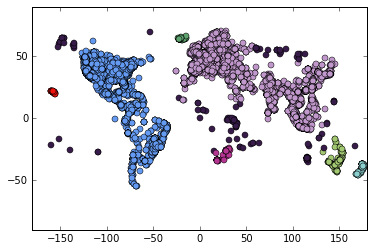

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for i in range(n_clusters_+1)]

fig, ax = plt.subplots()
ax.set_xlim((-180.0, 180.0))
ax.set_ylim((-90.0, 90.0))

i = 0
for label in db.labels_:
    ax.plot(coordinates[i][1], coordinates[i][0], marker='o', c=colors[(label+1)])
    i += 1

plt.show()

## KMeans

### Run the algorithm

In [6]:
from scipy.cluster.vq import kmeans2

k = 10
i = 700

centroids, closest_centroids = kmeans2(coordinates, k, iter=i)

centroids = [centroids[i] for i in range(len(centroids)) if i in set(closest_centroids)]

print "%d centroids" % len(centroids)

10 centroids


### Plot

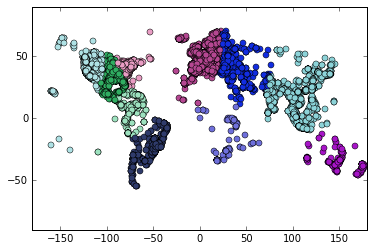

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for i in range(len(centroids))]

fig, ax = plt.subplots()
ax.set_xlim((-180.0, 180.0))
ax.set_ylim((-90.0, 90.0))

i = 0
for centroid in closest_centroids:
    ax.plot(coordinates[i][1], coordinates[i][0], marker='o', c=colors[centroid])
    i += 1

plt.show()

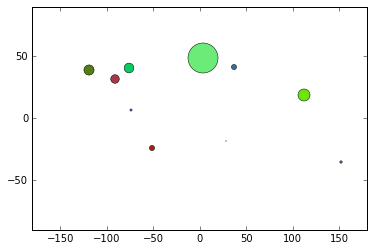

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

colors = [np.random.rand(3,1) for i in range(len(centroids))]

fig, ax = plt.subplots()
ax.set_xlim((-180.0, 180.0))
ax.set_ylim((-90.0, 90.0))

weight = [float(len([c for c in closest_centroids if c == i])) for i in range(len(centroids))]
weight = [w*len(centroids)*3/max(weight) for w in weight]

for i in range(len(centroids)):
    ax.plot(centroids[i][1], centroids[i][0], c=colors[i], marker='o', markersize=weight[i])

plt.show()

### Map

In [9]:
import folium
from IPython.display import HTML

def inline_map(m, width=800, height=600):
    """Takes a folium instance and embed HTML."""
    
    srcdoc = m._repr_html_().replace('"', '&quot;')
    embed = HTML('<iframe srcdoc="{}" '
                 'style="width: {}px; height: {}px; '
                 'border: none"></iframe>'.format(srcdoc, width, height))
    return embed


width, height = 800, 600
radars = folium.Map(location=[40, -122], zoom_start=1,
                    tiles='OpenStreetMap', width=width, height=height)

for centroid in centroids:
    folium.Marker([centroid[0], centroid[1]], ).add_to(radars) 

inline_map(radars)

# Format des images

## Ges photos

In [10]:
fullSet = flickr.loadDataFromFile('dataTest.json')

## Plot

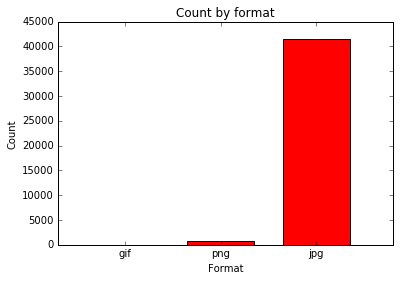

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

groups = set([p['originalformat'] for p in fullSet if p.has_key('originalformat') ])
groups = tuple(groups)
means = [len([p for p in fullSet if p.has_key('originalformat') and p['originalformat'] in group]) for group in groups]
means = tuple(means)
N = len(groups)

ind = np.arange(N)  # the x locations for the groups
width = 0.7       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar([i+width/2 for i in ind], means, width, color='r', yerr=range(N))

# add some text for labels, title and axes ticks
ax.set_xlabel('Format')
ax.set_ylabel('Count')
ax.set_title('Count by format')
ax.set_xticks(ind + width)
ax.set_xticklabels(groups)

plt.show()

# Dimensions des images

## Get photos

In [12]:
fullSet = flickr.loadDataFromFile('dataTest.json')

## KMeans

In [13]:
from scipy.cluster.vq import kmeans2

k = 20
i = 1000

dimensions = [(float(photo['o_width']), float(photo['o_height'])) for photo in fullSet if photo.has_key('o_width') and photo.has_key('o_height') and photo['o_width'] != 0 and photo['o_height'] != 0]
for d in dimensions:
    if d[0] > d[1]:
        d = (d[1],d[0])
dimensions = set(dimensions)
dimensions = [list(d) for d in dimensions]
centroids, closest_centroids = kmeans2(dimensions, k, iter=i)

centroids_used = set(closest_centroids)
centroids = [centroids[i] for i in range(len(centroids)) if i in centroids_used]

print "%d dimensions" % len(dimensions)
print "%d centroids" % len(centroids)

//anaconda/lib/python2.7/site-packages/scipy/cluster/vq.py:648: UserWarning: One of the clusters is empty. Re-run kmean with a different initialization.
  warnings.warn("One of the clusters is empty. "


2009 dimensions
19 centroids


### Plots

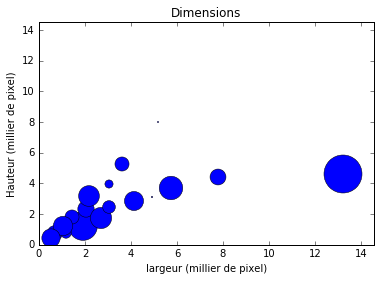

In [14]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots()

m = max([c[1] for c in centroids] + [c[0] for c in centroids])/1000
ax.set_xlim((0.0, m*1.1))
ax.set_ylim((0.0, m*1.1))

weight = [float(len([c for c in closest_centroids if c == i])) for i in range(len(centroids))]
weight = [w*len(centroids)*2/max(weight) for w in weight]

ax.set_xlabel('largeur (millier de pixel)')
ax.set_ylabel('Hauteur (millier de pixel)')
ax.set_title('Dimensions')

for i in range(len(centroids)):
    centroid = centroids[i]
    ax.plot(centroid[0]/1000, centroid[1]/1000, c='b', marker='o', markersize=weight[i])

plt.show()

In [15]:
from operator import itemgetter, attrgetter, methodcaller

def getPixelNumber(photo):
    return int(photo['o_width'])*int(photo['o_height'])

dimensionnedPhotos = [photo for photo in fullSet if photo.has_key('o_width') and photo.has_key('o_height') and photo['o_width'] != 0 and photo['o_height'] != 0]
dims = [getPixelNumber(photo) for photo in dimensionnedPhotos if getPixelNumber(photo) < 0.3e8]

(-1.0028815060680423, 1.0028631274050195, -1.0054238406203027, 1.0)

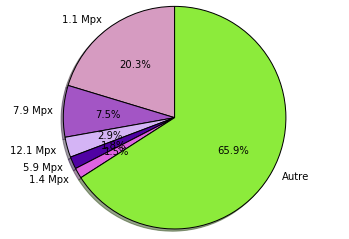

In [16]:
import matplotlib.pyplot as plt

means = []
for dim in set(dims):
    means += [(str(float(dim*10/(1000**2))/10) + " Mpx", len([d for d in dims if d == dim]))]

nbSlice = 5
means = sorted(means, key=itemgetter(1))[::-1]
means = [(m[0],m[1]) for m in means[:nbSlice]] + [('Autre', sum([m[1] for m in means[nbSlice:]]))]

# The slices will be ordered and plotted counter-clockwise.
labels = [m[0] for m in means]
sizes = [m[1] for m in means]
colors = [np.random.rand(3,1) for i in range(len(means))]

plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

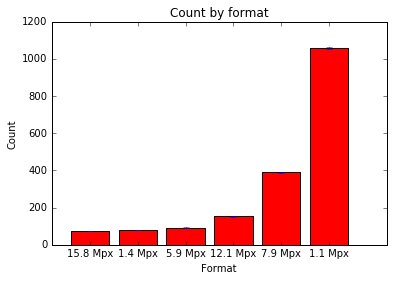

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt


means = []
for dim in set(dims):
    means += [(float(dim*10/(1000**2))/10, len([d for d in dims if d == dim]))]

means = sorted(means, key=itemgetter(1))[-6:]

groups = tuple([str(m[0]) + " Mpx" for m in means])
means = tuple([m[1] for m in means])
N = len(groups)

ind = np.arange(N)  # the x locations for the groups
width = 0.8       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar([i+width/2 for i in ind], means, width, color='r', yerr=range(N))

# add some text for labels, title and axes ticks
ax.set_xlabel('Format')
ax.set_ylabel('Count')
ax.set_title('Count by format')
ax.set_xticks(ind + width)
ax.set_xticklabels(groups)

plt.show()

## Convert centroids to GeoJSON

In [18]:
import json

def getFeature(coords):
    return {
        "type": "Feature",
        "properties" : {},
        "geometry" : {
            "type" : "Point",
            "coordinates" : [coords[1], coords[0]]
        }
    }

features = [getFeature(coords) for coords in centroids]

geoJson = {
    "type" : "FeatureCollection",
    "features" : features
}

print json.dumps(geoJson)

{"type": "FeatureCollection", "features": [{"geometry": {"type": "Point", "coordinates": [1248.7526315789473, 1903.6947368421052]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [2361.4722222222222, 2035.1944444444443]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [1816.1720430107528, 1442.258064516129]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [7998.5, 5187.75]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [2315.757575757576, 3799.121212121212]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [778.38571428571424, 708.97142857142853]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [1757.5032258064516, 2707.4322580645162]}, "type": "Feature", "properties": {}}, {"geometry": {"type": "Point", "coordinates": [3706.8709677419356, 5748.7204301075271]}, "type